In [1]:
import os
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as pp
import scipy.signal as sp
import scipy.stats as ss
import scipy.ndimage as nd
import scipy.spatial.distance as spd
import umap
import pandas as pd
import sklearn.manifold as sk
import sklearn.decomposition as sd

os.chdir('/Applications/SavedData')

In [2]:
fname = 'OpenBCI-RAW-2019-06-09_13-10-48.txt'
dat = np.loadtxt(fname, comments = '%', delimiter = ',', usecols = (0, 1, 2, 3, 4, 5, 7))

In [3]:
print(dat)

[[0.000000e+00 5.284026e+04 5.570396e+04 ... 3.999983e+04 7.823180e+03
  4.266239e+04]
 [1.000000e+00 5.298952e+04 5.580618e+04 ... 3.924110e+04 7.949080e+03
  4.234089e+04]
 [2.000000e+00 5.292068e+04 5.580835e+04 ... 3.955776e+04 7.959320e+03
  4.257645e+04]
 ...
 [8.800000e+01 5.311894e+04 5.492588e+04 ... 5.465182e+04 2.408197e+04
  5.554424e+04]
 [8.900000e+01 5.319002e+04 5.499200e+04 ... 5.436874e+04 2.414172e+04
  5.538000e+04]
 [9.000000e+01 5.309952e+04 5.496202e+04 ... 5.505825e+04 2.424232e+04
  5.583900e+04]]


In [5]:
transformer = sd.FastICA(n_components = 3)
isolated = np.reshape(dat[:,1], (1,-1))
lo_rep = transformer.fit_transform(isolated)

ValueError: Found array with 1 sample(s) (shape=(1, 364891)) while a minimum of 2 is required.

In [8]:
lo_rep.shape

(364891, 3)

In [5]:
# Define EEG bands
eeg_bands = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 45)}

In [109]:
tps = dat.shape[0]

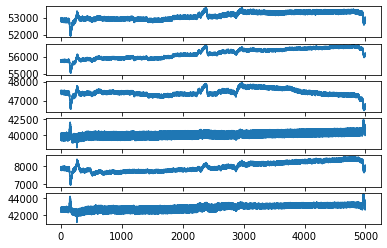

In [45]:
fig = pp.figure()

for t in range(6):
    pp.subplot(6,1,t+1)
    pp.plot(dat[1:(20*250),t+1])

In [6]:
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut/nyq
    high = highcut/nyq
    b, a = sp.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sp.lfilter(b, a, data)
    return y

In [7]:
fs = 250.0
lowcut = 1.0
highcut = 50.0

In [8]:
dat_prep = butter_bandpass_filter(dat, lowcut, highcut, fs, 4)

In [12]:
dat_prep.shape

(364891, 7)

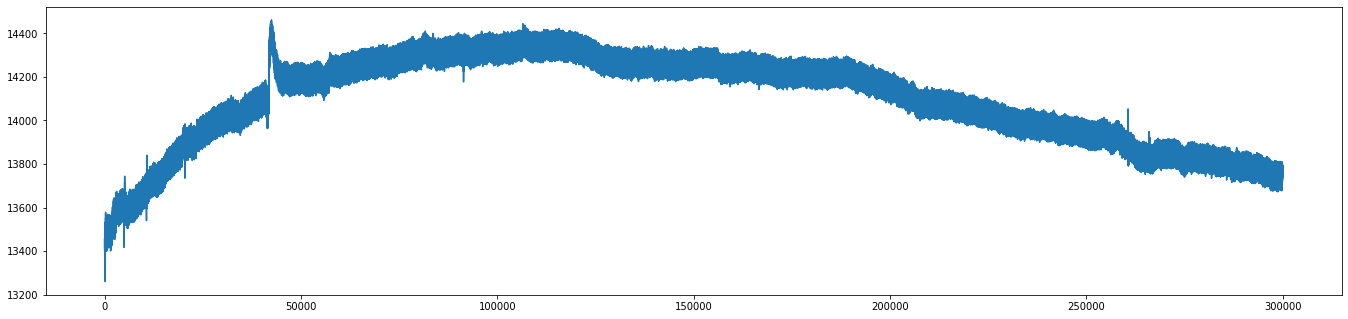

In [16]:
pp.axes([1, 1, 3, 1])
pp.plot(dat_prep[1:300000,2])

In [13]:
fs = 250
bpower = np.empty([1459,5*6])
for chan in range(0,5):
    for sec in range(0,1459):
        if sec == 0:
            start_idx = 0
        else:
            start_idx = (250*sec)
        end_idx = start_idx+249
        fft_vals = np.absolute(np.fft.rfft(dat_prep[start_idx:end_idx,chan+1]))
        fft_freq = np.fft.rfftfreq(250, 1.0/fs)
        eeg_band_fft = dict()
        for i, band in enumerate(eeg_bands):
            freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                               (fft_freq <= eeg_bands[band][1]))[0]
            bpower[sec,i+(chan*6)] = np.mean(fft_vals[freq_ix])

In [228]:
sum_power = np.empty([14,2])
for interval in range(0,14):
    if interval == 0:
        start_idx = 0
    else:
        start_idx = interval*100+1
    end_idx = start_idx+99
    sum_power[interval,0] = np.sum(bpower[start_idx:end_idx,13])

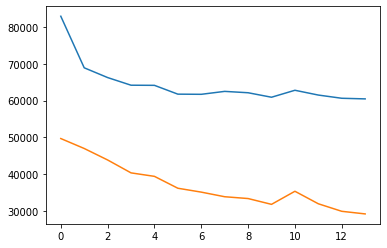

In [229]:
for interval in range(0,14):
    if interval == 0:
        start_idx = 0
    else:
        start_idx = interval*100+1
    end_idx = start_idx+99
    sum_power[interval,1] = np.sum(bpower[start_idx:end_idx,26])
    
pp.plot(sum_power)

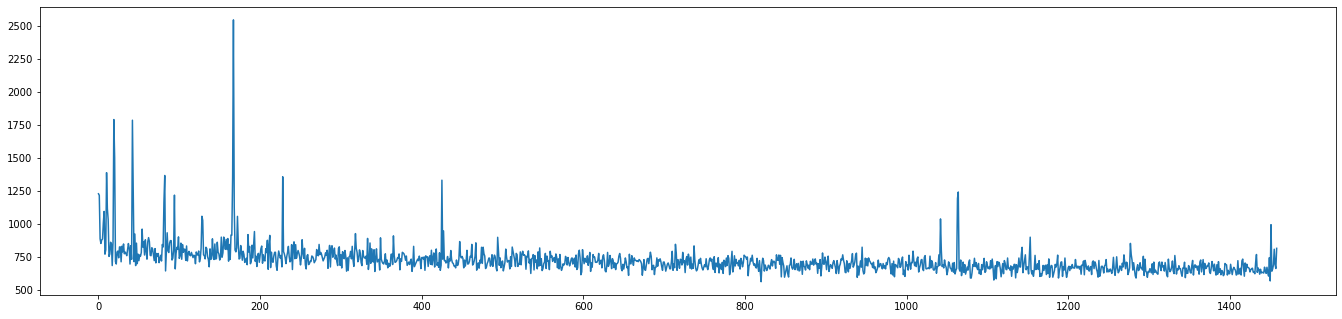

In [198]:
pp.axes([1, 1, 3, 1])
beta_sig = np.squeeze(np.sum(bpower[:,range(3,27,6)], axis = 1))
pp.plot(beta_sig)

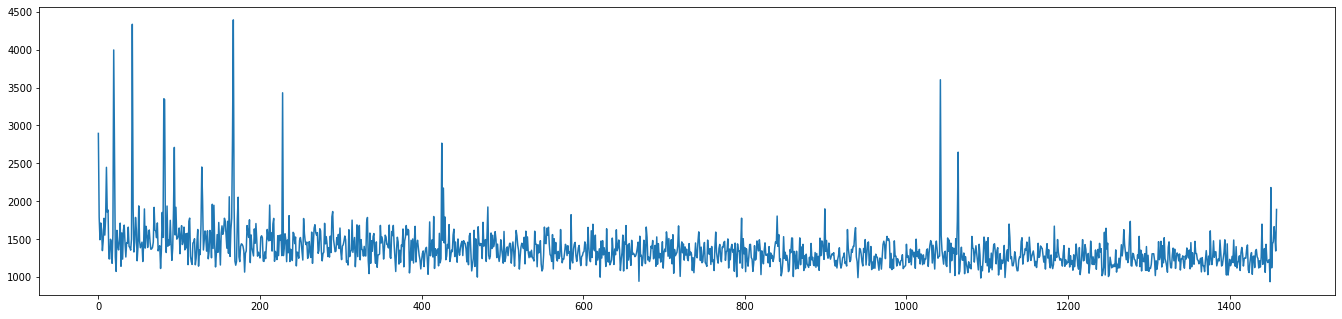

In [199]:
pp.axes([1, 1, 3, 1])
alpha_sig = np.squeeze(np.sum(bpower[:,range(2,26,6)], axis = 1))
pp.plot(alpha_sig)

In [206]:
pks, _ = sp.find_peaks(beta_sig, distance=3, prominence=300)

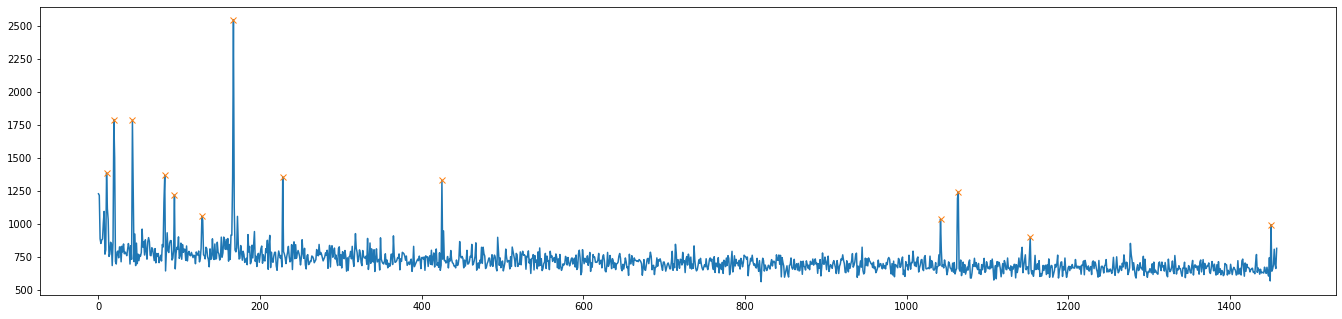

In [207]:
pp.axes([1, 1, 3, 1])
pp.plot(beta_sig)
pp.plot(pks, beta_sig[pks], "x")

In [208]:
print(pks)
print(durations)

[  10   19   42   82   94  128  167  228  425 1042 1064 1153 1451]
(0, 180, 459, 632, 1015, 1255, 1448)


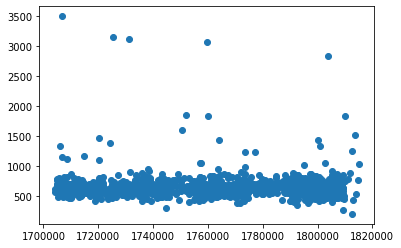

In [134]:
pp.scatter(bpower[:,12], bpower[:,13])

In [36]:
jumps = np.argsort(bpower[:,2])

In [66]:
durations = (0, 180, 180+279, 180+279+173, 180+279+173+383, 
             180+279+173+383+240, 180+279+173+383+240+193)
# Recomposed Winter 1: 43 to 223 = 180
# Recomposed Winter 3: 223 to 502 = 279
# Misty: 502 to 675 = 1177
# The man that got away: 675 to 1058
# She's a Lady: 1058 to 1298
# Dirty Little Secret: 1298 to 1491
song_timeline = np.zeros([1,1459])

In [75]:
for val in durations:
    song_timeline[0,val] = 1

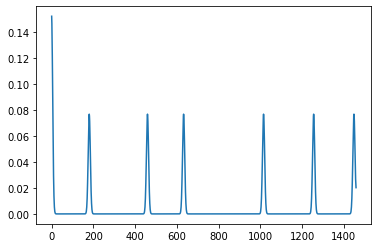

In [81]:
song_timeline = nd.gaussian_filter(song_timeline, 3)
pp.plot(song_timeline[0,:])

In [123]:
xcor = np.correlate(beta_sig, song_timeline[0,:], "full")

In [124]:
max(xcor)
lag = np.argmax(xcor)
print(lag)

1458


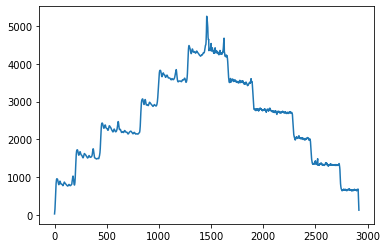

In [125]:
pp.plot(xcor)

In [191]:
tsne_embed = sk.TSNE(n_components=2,perplexity=20).fit_transform(bpower)

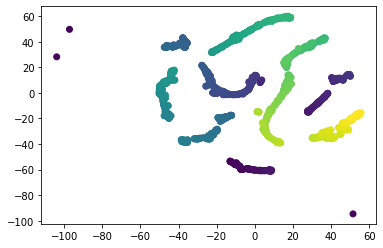

In [192]:
pp.scatter(tsne_embed[:,0],tsne_embed[:,1],c=range(0,1459))

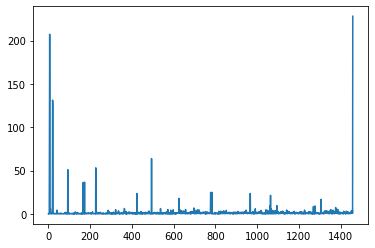

In [195]:
dist = np.empty(1459)
for tp in range(0,1458):
    dist[tp] = spd.euclidean(tsne_embed[tp,:], tsne_embed[tp+1,:])

pp.plot(dist)

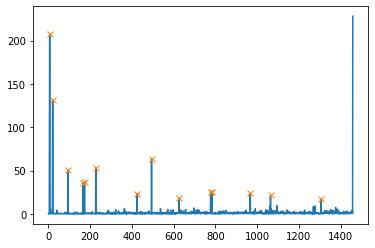

In [196]:
pks, _ = sp.find_peaks(dist, distance=3,prominence=10)
pp.plot(dist)
pp.plot(pks, dist[pks],"x")

In [197]:
print(pks)
print(durations)

[   6   20   93  166  173  227  424  494  625  777  783  967 1064 1306]
(0, 180, 459, 632, 1015, 1255, 1448)


In [24]:
kl_vals = np.empty(1458)
for pts in range(1, 1458):
    kl_vals[pts] = (ss.entropy(bpower[pts,:], bpower[pts-1,:]) + 
                    ss.entropy(bpower[pts-1,:], bpower[pts,:]))/2

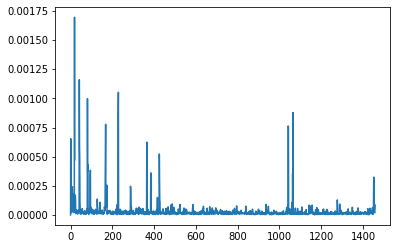

In [25]:
pp.plot(kl_vals)

In [193]:
    eeg_band_fft = dict()
    for band in eeg_bands:  
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq <= eeg_bands[band][1]))[0]
        eeg_band_fft[band] = np.mean(fft_vals[freq_ix])

In [194]:
eeg_band_fft

{'Alpha': 18636.83154952436,
 'Beta': 18727.542347044822,
 'Delta': 18672.045924020775,
 'Gamma': 18735.271843468407,
 'Theta': 18653.71209480593}

In [195]:
eeg_band_fft.append(eeg_band_fft)

AttributeError: 'dict' object has no attribute 'append'

Text(0, 0.5, 'Mean band Amplitude')

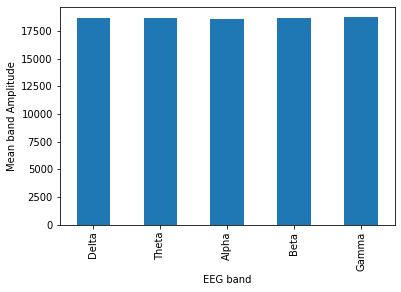

In [100]:
# Plot the data (using pandas here cause it's easy)
df = pd.DataFrame(columns=['band', 'val'])
df['band'] = eeg_bands.keys()
df['val'] = [eeg_band_fft[band] for band in eeg_bands]
ax = df.plot.bar(x='band', y='val', legend=False)
ax.set_xlabel("EEG band")
ax.set_ylabel("Mean band Amplitude")

In [91]:
print(eeg_band_fft)

{'Delta': 18709.813116640806, 'Theta': 18725.96308466789, 'Alpha': 18776.690325364976, 'Beta': 18863.20685576027, 'Gamma': 18874.2196990448}


In [44]:
dat_det = sp.detrend(dat, 1)
sub_dat = dat_det[range(2,150002,50),0:5]

In [77]:
fit = umap.UMAP()
embedding = fit.fit_transform(dat_prep[range(1,(250*25),50),1:6])

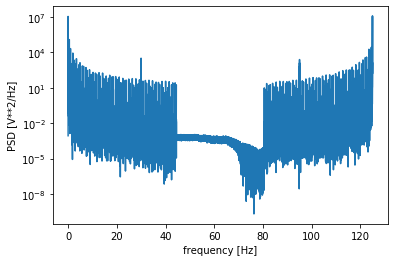

In [79]:
f, Pxx_den = sp.periodogram(dat_prep[:,4], fs)
pp.semilogy(f, Pxx_den)
pp.xlabel('frequency [Hz]')
pp.ylabel('PSD [V**2/Hz]')
pp.show()

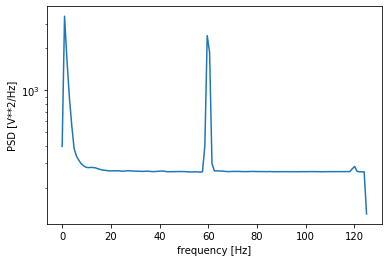

In [64]:
f, Pxx_den = sp.welch(dat[:,1], fs)
pp.semilogy(f, Pxx_den)
pp.xlabel('frequency [Hz]')
pp.ylabel('PSD [V**2/Hz]')
pp.show()

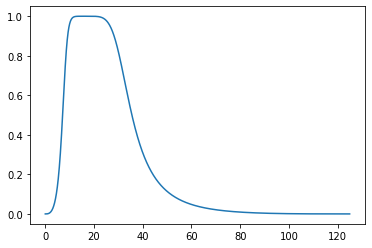

In [70]:
pp.figure(1)
pp.clf()
b, a = butter_bandpass(lowcut, highcut, fs, 3)
w, h = sp.freqz(b, a, worN=2000)

pp.plot((fs*0.5/np.pi)*w, abs(h))